## Probability

### Dice Rolls and Probability Distributions

This notebook builds on the [previous notebook on probability modeling in Python](https://github.com/practicallypredictable/posts/blob/master/notebooks/probability-part1-poker_hands.ipynb). In this notebook, we will discuss the concept of [_probability distribution_](https://en.wikipedia.org/wiki/Probability_distribution) and how to represent it in Python. Our previous discussion on [classical probabilty](https://en.wikipedia.org/wiki/Classical_definition_of_probability) only dealt with situations where all outcomes are equally likely. That's not a very realistic framework for analyzing sports or other real-world scenarios. In this notebook, we'll look at how even simple dice rolls introduces unequal probabilities, and why we need distributions to represent the outcomes. Looking forward to future posts, we will analyze some interesting board games and start estimating win probabilities in basketball and baseball.

As in the previous notebook, the Python framework developed here is inspired by and borrows from two excellent sources: [Peter Norvig's](http://norvig.com/) [Concrete Introduction to Probability (using Python)](https://github.com/norvig/pytudes/blob/master/ipynb/Probability.ipynb) and [Allen Downey's](http://www.allendowney.com/wp/) [blog post on using the Python `Counter` class to represent probability mass functions](https://allendowney.blogspot.com/2014/05/implementing-pmfs-in-python.html). I highly recommend these two sources to you, and hope that you find the approach I've taken here combines some of the best aspects of each.

### Independent Dice Rolls

A fair six-sided die has equally likely outcomes. Each side can land face-up with probability $\frac 1 6$.

Now assume that we have two fair six-sided dice, which are labelled so we can tell them apart. Call them $D_1$ and $D_2$. Our experiment is to roll both dice at the same time and observe which faces land up. If we assume that the outcome on $D_1$ has no impact on the outcome on $D_2$ (and vice versa), then the outcomes are [_independent_](https://en.wikipedia.org/wiki/Independence_(probability_theory)). Even though it may seem physically obvious that two fair dice should have indepdent outcomes, we should always remember that independence is an assumption that must be carefully thought through. Many errors in probability and statistics occur from wrongly assuming independence.

Assuming independence of $D_1$ and $D_2$, there are $6^2 = 36$ possible combined outcomes from rolling both dice at the same time. We can have 1 through 6 for $D_1$, and 1 through 6 for $D_2$, and the 36 possible outcomes are the [Cartesian product](https://en.wikipedia.org/wiki/Cartesian_product) of the $D_1$ and $D_2$ outcomes. Some possible example outcomes are (1, 5), (2, 4) and (4, 2). The ordered pairs show the outcome of $D_1$ first, followed by the outcome of $D_2$. Notice that (2, 4) and (4, 2) are different outcomes.

So far, this isn't very different from the poker hands analysis we did in the previous notebook. There are 36 possible outcomes, and each are equally likely with probability $\frac 1 {36}$.

### Sum of Dice Rolls

In most games, however, we usually don't keep track of specific dice ($D_1$ vs. $D_2$). We look at outcomes such as the sum of the two dice, and whether we've rolled doubles (both dice showing the same number). In the board game [Monopoly](https://en.wikipedia.org/wiki/Monopoly_(game), we move our token based on the sum of the dice rolls, and if we've rolled doubles, we can roll again.

Looking at the example outcomes above, it's obvious that the outcomes cannot be equally likely if we care about the sum of the dice rolls. The outcomes (1, 5), (2, 4) and (4, 2) all have sum 6. There are actually 5 outcomes that have sum 6. We need to include (5, 1) and (3, 3) as well. Notice also that there are 11 possible outcomes for the sum of two dice, ranging between 2 and 12.

If we roll three dice, there are $6^3 = 216$ possible outcomes if we keep track of the specific dice, but only 16 outcomes (between 3 and 18) for the sum. Again, the sum of the rolls are not equally likely outcomes. Can you guess which outcomes are most likely for the two and three dice rolls?

### Probability Distributions

For the sum of dice, we can still use the machinery of classical probability to a limited extent.

If we want to know the probability of having the sum of two dice be 6, we can work with the 36 underlying outcomes of the form $(D_1, D_2)$ and define the event of interest $A$ to be the set of outcomes such $D_1 + D_2 = 36$. Then $P(A) = \frac 5 {36}$ from the usual rules of classical probability.

However, it's much better to just keep track of the possible outcomes and their (not necessarily equal) probabilities. This will be very useful for handing more complicated situations than dice rolls.

There are several possible ways to represent a mathematical probability distribution. Here, we are going to focus on the [_probability mass function_](https://en.wikipedia.org/wiki/Probability_mass_function) (or PMF) for representing distributions on discrete finite sample spaces. A PMF is basically just a mapping between an outcome and its probability, with the additional rule that the sum of the probabilities over all possible outcomes must equal 1.

### A Quick Note about Interpretations of Probability

When we talk about probability distributions, we are moving away from classical probability and toward more general and abstract concepts. One advantage of classical probability is that it fits with our physical intuition about games of chance and other familiar situations. However, classical probability isn't immune to criticism. The English mathematician [John Venn](https://en.wikipedia.org/wiki/John_Venn) (the inventor of the famous [Venn diagram](https://en.wikipedia.org/wiki/Venn_diagram)) and others in the nineteenth century felt that probability theory was on shaky ground. In the 1930s, the great Russian mathematican [Andrei Kolmogorov](https://plato.stanford.edu/entries/probability-interpret/#KolProCal) put probability on firm mathematical footing.

Even though the mathematics of probability is well-established, there is still significant debate even today about [what, if anything, probability means in the real world](https://en.wikipedia.org/wiki/Probability_interpretations).

We are going to side-step debates over [Frequentist](https://en.wikipedia.org/wiki/Frequentist_probability) versus [Bayesian](https://en.wikipedia.org/wiki/Bayesian_probability) interpretations of probability, at least for the time being.

### Representing Probability Distributions in Python

In Python, the built-in [`Counter`](https://docs.python.org/3/library/collections.html) class is a very good way to represent the mapping of a probability distribution. We will also continue to represent the numerical value of probability using Python's built-in [`Fraction`](https://docs.python.org/3/library/fractions.html) class, since probabilities are ratios and `Fraction` can represent them exactly.

In [1]:
from fractions import Fraction
from collections import Counter
import itertools as it

We will do some plotting at the end.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_context('notebook')
plt.style.use('ggplot')

Let's start off with the outcomes of a fair six-sided die roll.

In [3]:
d6 = Counter(range(1,7))
d6

Counter({1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1})

Here are the functions we defined in our [previous notebook](https://github.com/practicallypredictable/posts/blob/master/notebooks/probability-part1-poker_hands.ipynb) to represent classical probability. We'll expand on these functions shortly.

In [4]:
def such_that(condition_true_for, space):
    """Subset of sample space for which a condition is true."""
    return {element for element in space if condition_true_for(element)}

In [5]:
def prob(event, space):
    """Classical probability (revised version)."""
    if callable(event):
        event = such_that(event, space)
    return Fraction(len(set(event) & set(space)), len(space))

As a review, here's the probability of rolling a 2 on our (mathematical) six-sided die.

In [6]:
prob({2}, d6)

Fraction(1, 6)

And here is the probability of rolling an even number.

In [7]:
def is_even(n):
    return n % 2 == 0

In [8]:
prob(is_even, d6)

Fraction(1, 2)

Now let's generate the outcomes from rolling two fair, independent dice using the Cartesian product.

In [9]:
d6x2 = list(it.product(d6, d6))
len(d6x2)

36

These outcomes keep track of the specific dice, so the outcomes are `tuples`. The outcome (1, 5) is different from (5, 1).

In [10]:
d6x2[:10]

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4)]

If we really just want to keep track of the sum of the rolls, we need something different.

In [11]:
sum_d6x2 = Counter(i+j for i, j in it.product(d6, d6))
len(sum_d6x2)

11

In [12]:
sum_d6x2.most_common(11)

[(7, 6),
 (6, 5),
 (8, 5),
 (5, 4),
 (9, 4),
 (4, 3),
 (10, 3),
 (3, 2),
 (11, 2),
 (2, 1),
 (12, 1)]

The most common outcome for the sum of two dice is 7, which is halfway between the minimum value of 2 and the maximum value of 12. The sum of the possible outcomes is 36.

In [13]:
sum(sum_d6x2.values())

36

Here are the same results for the sum of three fair, indpendent dice.

In [14]:
sum_d6x3 = Counter(i+j+k for i, j, k in it.product(d6, d6, d6))
len(sum_d6x3)

16

In [15]:
sum_d6x3.most_common(16)

[(10, 27),
 (11, 27),
 (9, 25),
 (12, 25),
 (8, 21),
 (13, 21),
 (7, 15),
 (14, 15),
 (6, 10),
 (15, 10),
 (5, 6),
 (16, 6),
 (4, 3),
 (17, 3),
 (3, 1),
 (18, 1)]

The most common values for the sum of three dice is a tie between 10 and 11, which straddle the half-way point between the minimum value of 3 and the maximum value of 18.

In [16]:
sum(sum_d6x3.values())

216

Now we will see how easy it is to represent a probability distribution for sum of dice using Python's `Counter` class.

In [17]:
p = Counter()
total = sum(sum_d6x2.values())
for roll, roll_count in sum_d6x2.items():
    p[roll] = Fraction(roll_count, total)
p

Counter({2: Fraction(1, 36),
         3: Fraction(1, 18),
         4: Fraction(1, 12),
         5: Fraction(1, 9),
         6: Fraction(5, 36),
         7: Fraction(1, 6),
         8: Fraction(5, 36),
         9: Fraction(1, 9),
         10: Fraction(1, 12),
         11: Fraction(1, 18),
         12: Fraction(1, 36)})

Given how often we need to analyze probability, we should invest some time to do it correctly.

Let's represent a probability distribution using a new Python class which inherits from `Counter`. As [professor Allen Downey points out](https://allendowney.blogspot.com/2016/06/what-is-distribution.html), [object-oriented programming](https://en.wikipedia.org/wiki/Object-oriented_programming) is a useful framework for expressing abstract mathematical ideas. We will follow his advice and create some new object types.

A discrete PMF is just a mapping of outcomes and representation of the relative frequency of each outcome. Our new `ProbDist` class will [inherit](https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming) from `Counter`, so all of the underlying functionality of `Counter` are available to it. Also, any part of the Python ecosystem that can work with a `dict`-like object such as `Counter` can work with our distribution object also.

Since we want our distribution object to have probabilities and not counts of the outcomes, all we need to do is divide each of the counts by the total count. This automatically makes the probabilities sum to 1. Our distribution object will store the resulting probabilities using Python's `Fraction` class.

In [18]:
class ProbDist(Counter):
    """Discrete finite probability distribution."""
    def __init__(self, mapping=(), **kwargs):
        self.update(mapping, **kwargs)
        total = sum(self.values())
        for event in self:
            if self[event] < 0:
                raise ValueError('probability cannot be negative')
            self[event] = Fraction(self[event], total)

As noted above, our implementation of `ProbDist` also borrows some ideas from [Peter Norvig's notebook on probability modeling which you can find here](https://nbviewer.jupyter.org/url/norvig.com/ipython/Probability.ipynb).

Now we can represent our dice rolls using this new class.

In [19]:
ProbDist(d6)

ProbDist({1: Fraction(1, 6),
          2: Fraction(1, 6),
          3: Fraction(1, 6),
          4: Fraction(1, 6),
          5: Fraction(1, 6),
          6: Fraction(1, 6)})

In [20]:
ProbDist(sum_d6x2)

ProbDist({2: Fraction(1, 36),
          3: Fraction(1, 18),
          4: Fraction(1, 12),
          5: Fraction(1, 9),
          6: Fraction(5, 36),
          7: Fraction(1, 6),
          8: Fraction(5, 36),
          9: Fraction(1, 9),
          10: Fraction(1, 12),
          11: Fraction(1, 18),
          12: Fraction(1, 36)})

We need to make some small changes to our probability functions to make use of the new `ProbDist` class.

In [21]:
def such_that(condition_true_for, space):
    """Subset of sample space for which a condition is true (revised for finite discrete distributions)."""
    if isinstance(space, ProbDist):
        return ProbDist({element: space[element] for element in space if condition_true_for(element)})
    else:
        return {element for element in space if condition_true_for(element)}

In [22]:
def prob(event, space):
    """Probability of an event (classical or defined by a finite discrete distribution)."""
    if callable(event):
        event = such_that(event, space)
    if isinstance(space, ProbDist):
        return sum(space[element] for element in space if element in event)
    else:
        return Fraction(len(set(event) & set(space)), len(space))

Let's check if it correctly computes the probability that the sum of two dice exceeds 4.

In [23]:
such_that(lambda n: n > 4, sum_d6x2)

{5, 6, 7, 8, 9, 10, 11, 12}

In [24]:
[sum_d6x2[x] for x in such_that(lambda n: n > 4, sum_d6x2)]

[4, 5, 6, 5, 4, 3, 2, 1]

In [25]:
sum([sum_d6x2[x] for x in such_that(lambda n: n > 4, sum_d6x2)])

30

In [26]:
prob(lambda n: n > 4, ProbDist(sum_d6x2))

Fraction(5, 6)

This is correct. If we keep track of the underlying specific dice, there are 30 outcomes which have a sum > 4, and there are 36 total outcomes. The `ProbDist` class keeps track of all the math for us automatically.

Because we will be working with probabilities so much on this site, I decided to create a Python package called `pracpred` for representing probabilities and other tools that we will use repeatedly. [Here is the source code for the package](https://github.com/practicallypredictable/pracpred). The package actually includes some modules other than just probability modeling, but you can ignore those for now.

Please note that the implementation and functionality is much more complex in the package than in the simpler code used above in this notebook. The basic approach is very similar, however. Feel free to examine the package source code, or ignore it if you'd prefer to just focus on the results.

The package has been [uploaded to PyPI](https://pypi.python.org/pypi?:action=display&name=pracpred&version=0.1.0). You can download and install it in your environment using [`pip`](https://pypi.python.org/pypi/pip), the official tool for installing Python packages. This is one exception we will make to using Anaconda to install packages. Fortunately, `pip` and Anaconda work very well together, and you can install the `pracpred` package in your sports analytics environment by executing the command below in Jupyter Notebook:

In [27]:
%%capture
!pip install pracpred

You can ignore the `%%capture` magic method in your notebook if you wish. I used it to avoid including command output here. In Jupyter Notebook, use the `!` before the `pip` command to tell Notebook that you are executing an operating system command. You can also run the `pip` command in Terminal or the Anaconda Prompt. If you do, ignore the `%%capture` line and don't include the initial `!`.

Going forward, we'll assume that `pracpred` is installed in your sports analytics environment.

Now let's import and use the probability package.

In [28]:
import pracpred.prob as ppp

Here is the fair six-sided die again, this time as a `ProbDist`.

In [29]:
d6 = ppp.ProbDist(range(1,7))
d6

ProbDist({1: Prob(1, 6), 2: Prob(1, 6), 3: Prob(1, 6), 4: Prob(1, 6), 5: Prob(1, 6), 6: Prob(1, 6)})

Notice that the probabilities are stored as type `Prob` rather than `Fraction`. If you look at the source code, you'll see that `Prob` inherits from `Fraction` and includes some other functionality specific to probabilities. But for most purposes, it works just like `Fraction`.

We will repeat some of the above analysis of dice rolls as a quick demonstration of how to use the `ProbDist` class.

If you want to get a probability from our `ProbDist`, use the `prob()` method.

In [30]:
d6.prob({2})

Prob(1, 6)

In [31]:
d6.prob(is_even)

Prob(1, 2)

The `subset_such_that()` method returns the subset of the sample space for which a condition is true.

In [32]:
d6.subset_such_that(is_even)

{2, 4, 6}

The `such_that()` method returns a new `ProbDist` where the outcomes are a subset of the sample space for which a condition is true. Notice that the probabilities have been rescaled so they add to 1 for this new `ProbDist`.

In [33]:
d6.such_that(is_even)

ProbDist({2: Prob(1, 3), 4: Prob(1, 3), 6: Prob(1, 3)})

If you want to represent a joint distribution of two independent probability distributions, use the `repeated()` method. An example would be rolling two six-sided dice.

In [34]:
d6.repeated(2)

ProbDist({2: Prob(1, 36), 3: Prob(1, 18), 4: Prob(1, 12), 5: Prob(1, 9), 6: Prob(5, 36), 7: Prob(1, 6), 8: Prob(5, 36), 9: Prob(1, 9), 10: Prob(1, 12), 11: Prob(1, 18), 12: Prob(1, 36)})

Notice that `repeated()` assumes that you want to sum (for numbers) or concatenate (for strings) to group the outcomes. If you really want to keep track of each of the specific events from the full Cartesian product, you can pass the optional parameter `product=True`.

In [35]:
d6x2 = d6.repeated(2, product=True)
len(d6x2)

36

In [36]:
d6x2

ProbDist({(1, 1): Prob(1, 36), (1, 2): Prob(1, 36), (1, 3): Prob(1, 36), (1, 4): Prob(1, 36), (1, 5): Prob(1, 36), (1, 6): Prob(1, 36), (2, 1): Prob(1, 36), (2, 2): Prob(1, 36), (2, 3): Prob(1, 36), (2, 4): Prob(1, 36), (2, 5): Prob(1, 36), (2, 6): Prob(1, 36), (3, 1): Prob(1, 36), (3, 2): Prob(1, 36), (3, 3): Prob(1, 36), (3, 4): Prob(1, 36), (3, 5): Prob(1, 36), (3, 6): Prob(1, 36), (4, 1): Prob(1, 36), (4, 2): Prob(1, 36), (4, 3): Prob(1, 36), (4, 4): Prob(1, 36), (4, 5): Prob(1, 36), (4, 6): Prob(1, 36), (5, 1): Prob(1, 36), (5, 2): Prob(1, 36), (5, 3): Prob(1, 36), (5, 4): Prob(1, 36), (5, 5): Prob(1, 36), (5, 6): Prob(1, 36), (6, 1): Prob(1, 36), (6, 2): Prob(1, 36), (6, 3): Prob(1, 36), (6, 4): Prob(1, 36), (6, 5): Prob(1, 36), (6, 6): Prob(1, 36)})

You can chain methods together.

In [37]:
d6.repeated(2).most_common(11)

[(7, Prob(1, 6)),
 (6, Prob(5, 36)),
 (8, Prob(5, 36)),
 (5, Prob(1, 9)),
 (9, Prob(1, 9)),
 (4, Prob(1, 12)),
 (10, Prob(1, 12)),
 (3, Prob(1, 18)),
 (11, Prob(1, 18)),
 (2, Prob(1, 36)),
 (12, Prob(1, 36))]

In [38]:
d6.repeated(2).prob(lambda n: n > 4)

Prob(5, 6)

Here's the probability of rolling doubles in Monopoly.

In [39]:
d6.repeated(2, product=True).prob(lambda dice: dice[0] == dice[1])

Prob(1, 6)

In [40]:
x1, y1 = d6.zipped
x2, y2 = d6.repeated(2).zipped
x3, y3 = d6.repeated(3).zipped

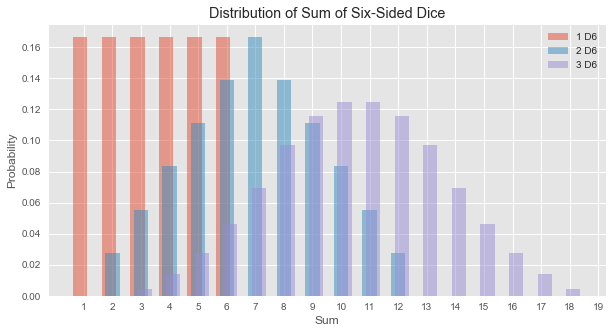

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
width = 0.5
ax.bar([x-width/4 for x in x1], y1, width, alpha=0.5, label='1 D6')
ax.bar([x for x in x2], y2, width, alpha=0.5, label='2 D6')
ax.bar([x+width/4 for x in x3], y3, width, alpha=0.5, label='3 D6')
ax.set_xticks(range(1, max(x3)+2))
ax.set_xlabel('Sum')
ax.set_ylabel('Probability')
ax.set_title(f'Distribution of Sum of Six-Sided Dice')
ax.legend(loc='upper right')
plt.show()